In [65]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp 


In [66]:


tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors




## toy data

In [67]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()



In [68]:
x.shape



(150, 1)

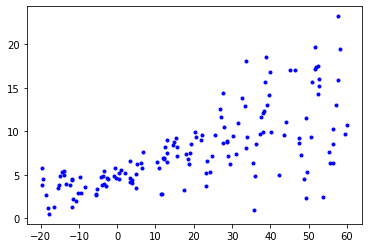

In [71]:

plt.plot(x, y, 'b.', label='observed')
plt.show()



## Sklearn Linear Reg

In [72]:
from sklearn.linear_model import LinearRegression

In [75]:
lr = LinearRegression().fit(x, y)

yhat_lr_sk = lr.predict(x_tst)



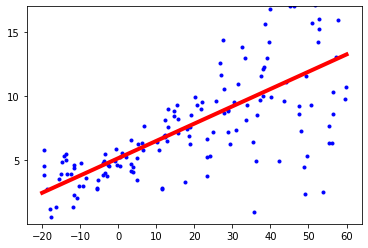

In [76]:
plt.plot(x, y, 'b.', label='observed')
plt.plot(x_tst, yhat_lr_sk,'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.show()





## DNN-Reg

In [6]:
n_units = 2
n_epochs = 1000
n_features = x.shape[1]
learning_rate = 1e-3

optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)



In [7]:

# Build model.
model_mse = tfk.Sequential([
    tfk.layers.Dense(units=1, input_shape=[n_features,],), 
])

# Do inference.
model_mse.compile(loss="mse", optimizer=optimizer, )

history_mse = model_mse.fit(x=x, y=y, epochs=n_epochs)


yhat_mse = model_mse(x_tst)

Epoch 1/1000
5/5 [==============================] - 0s 645us/step - loss: 477.6724
Epoch 2/1000
5/5 [==============================] - 0s 605us/step - loss: 470.8855
Epoch 3/1000
5/5 [==============================] - 0s 654us/step - loss: 464.3373
Epoch 4/1000
5/5 [==============================] - 0s 806us/step - loss: 457.9033
Epoch 5/1000
5/5 [==============================] - 0s 490us/step - loss: 451.8094
Epoch 6/1000
5/5 [==============================] - 0s 618us/step - loss: 445.2927
Epoch 7/1000
5/5 [==============================] - 0s 600us/step - loss: 438.7793
Epoch 8/1000
5/5 [==============================] - 0s 448us/step - loss: 432.7873
Epoch 9/1000
5/5 [==============================] - 0s 491us/step - loss: 426.7594
Epoch 10/1000
5/5 [==============================] - 0s 485us/step - loss: 420.8214
Epoch 11/1000
5/5 [==============================] - 0s 536us/step - loss: 414.5955
Epoch 12/1000
5/5 [==============================] - 0s 515us/step - loss: 408.8157
E

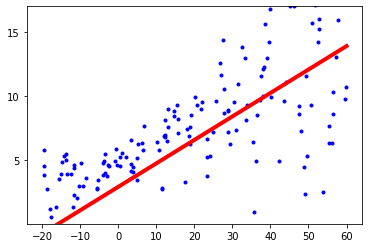

In [8]:

plt.plot(x, y, 'b.', label='observed')
plt.plot(x_tst, yhat_mse,'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.show()








## DNN-Reg a bit denser

In [77]:

# Build model.
model_mse_d = tfk.Sequential([
    tfk.layers.Dense(units=5, input_shape=[n_features,],),  
    tfk.layers.Dense(units=1, input_shape=[n_features,],),  
])

# Do inference.
model_mse_d.compile(loss="mse", optimizer=optimizer, )

history_mse_d = model_mse_d.fit(x=x, y=y, epochs=n_epochs)


yhat_mse_d = model_mse_d(x_tst)

Epoch 1/1000
5/5 [==============================] - 0s 566us/step - loss: 33.3812
Epoch 2/1000
5/5 [==============================] - 0s 642us/step - loss: 25.7004
Epoch 3/1000
5/5 [==============================] - 0s 671us/step - loss: 27.6669
Epoch 4/1000
5/5 [==============================] - 0s 749us/step - loss: 24.4609
Epoch 5/1000
5/5 [==============================] - 0s 567us/step - loss: 23.8981
Epoch 6/1000
5/5 [==============================] - 0s 702us/step - loss: 23.9602
Epoch 7/1000
5/5 [==============================] - 0s 581us/step - loss: 22.8782
Epoch 8/1000
5/5 [==============================] - 0s 596us/step - loss: 22.5782
Epoch 9/1000
5/5 [==============================] - 0s 586us/step - loss: 21.9675
Epoch 10/1000
5/5 [==============================] - 0s 583us/step - loss: 21.5674
Epoch 11/1000
5/5 [==============================] - 0s 535us/step - loss: 21.1581
Epoch 12/1000
5/5 [==============================] - 0s 581us/step - loss: 20.7736
Epoch 13/1000

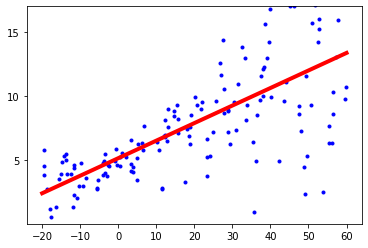

In [78]:

plt.plot(x, y, 'b.', label='observed')
plt.plot(x_tst, yhat_mse_d,'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.show()








# Probabilistic Regression to consider uncertainties 

- Let the probability distribution of labels:$P(y|x, w)$; 
    - where $y$ is the label_prob, $x$ is the data point and $w$ is the model's parameters to be learned.
    
- Thus the problem is minimized the negative log likelihood loss, $-log P(y|x, w)$.


In python: negloglik = lambda x, rv_x: -rv_x.log_prob(x)

In [9]:

negloglik = lambda x, rv_x: -rv_x.log_prob(x)




## Simple Linear Regression (No Uncertainty)

In [10]:

# Build model.
model_lr = tfk.Sequential([
    tfk.layers.Dense(units=1, input_shape=[n_features,],),  # a float that paramterizing the normal distribution mean
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., 0], 
                                 scale=1)),  # we replace the ordinary MSE with a distribution which is RV
])

# Do inference.
model_lr.compile(loss=negloglik, optimizer=optimizer, )

history_lr = model_lr.fit(x=x, y=y, epochs=n_epochs)


yhat_lr = model_lr(x_tst)
yhat_lr_samples = yhat_lr.sample()

Epoch 1/1000
5/5 [==============================] - 0s 568us/step - loss: 1180.0316
Epoch 2/1000
5/5 [==============================] - 0s 638us/step - loss: 1140.3157
Epoch 3/1000
5/5 [==============================] - 0s 688us/step - loss: 1092.8796
Epoch 4/1000
5/5 [==============================] - 0s 654us/step - loss: 1046.8466
Epoch 5/1000
5/5 [==============================] - 0s 652us/step - loss: 1007.2594
Epoch 6/1000
5/5 [==============================] - 0s 671us/step - loss: 963.5945
Epoch 7/1000
5/5 [==============================] - 0s 623us/step - loss: 933.5162
Epoch 8/1000
5/5 [==============================] - 0s 576us/step - loss: 897.7430
Epoch 9/1000
5/5 [==============================] - 0s 670us/step - loss: 863.7745
Epoch 10/1000
5/5 [==============================] - 0s 585us/step - loss: 836.0643
Epoch 11/1000
5/5 [==============================] - 0s 565us/step - loss: 812.3020
Epoch 12/1000
5/5 [==============================] - 0s 571us/step - loss: 789.3

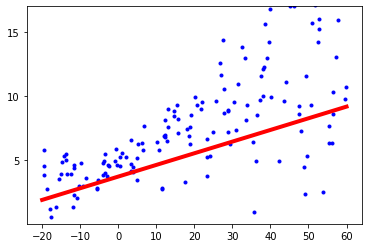

In [11]:

plt.plot(x, y, 'b.', label='observed')
plt.plot(x_tst, yhat_lr.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.show()







- something fishy here: as the magnitude of x increases, variance of y also increases. Thus probably our model, should be suspicious.

- we did not learn variance of data points. 
    - (e.g the variance of flipping a coin: doesn't matter how much data we have, with this model we cannot predict the upcoming data point label)
    
- Thus we will learn this from the data itself, by adding one more float to our dense_layer output

## modeling Aleatoric Uncertainty (Known Unknowns)

- learning a variants of data points (similar to MSE)

In [15]:
# Build model.
model_al = tfk.Sequential([
    # we can add more tfk.layers here as usual
    tfk.layers.Dense(units=(1+1), input_shape=[n_features,],),  # two floats >> mean and scale of normal dist.
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], 
                                                      scale=1e-3+tf.math.softplus(0.05*t[..., 1:]))),
])

# Do inference.
model_al.compile(loss=negloglik, optimizer=optimizer)

history_al = model_al.fit(x=x, y=y, epochs=n_epochs)

yhat_al = model_al(x_tst)
yhat_al_samples = yhat_al.sample()

Epoch 1/1000
5/5 [==============================] - 0s 628us/step - loss: 984.6433
Epoch 2/1000
5/5 [==============================] - 0s 576us/step - loss: 881.5305
Epoch 3/1000
5/5 [==============================] - 0s 561us/step - loss: 775.0482
Epoch 4/1000
5/5 [==============================] - 0s 613us/step - loss: 686.2840
Epoch 5/1000
5/5 [==============================] - 0s 644us/step - loss: 614.9064
Epoch 6/1000
5/5 [==============================] - 0s 600us/step - loss: 556.0303
Epoch 7/1000
5/5 [==============================] - 0s 671us/step - loss: 508.4742
Epoch 8/1000
5/5 [==============================] - 0s 632us/step - loss: 467.8412
Epoch 9/1000
5/5 [==============================] - 0s 625us/step - loss: 435.0196
Epoch 10/1000
5/5 [==============================] - 0s 607us/step - loss: 408.1634
Epoch 11/1000
5/5 [==============================] - 0s 630us/step - loss: 383.0182
Epoch 12/1000
5/5 [==============================] - 0s 491us/step - loss: 363.1195
E

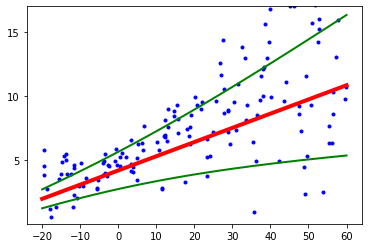

In [16]:
m = yhat_al.mean()
s = yhat_al.stddev()

plt.plot(x, y, 'b.', label='observed');

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));



- read line is the mean and green lines are std. 



- Although the situation is better, now the question is: "how do we know that we have enough data?," is there "anything else we can do?", ... 

- Answer: of course, there is: why should we learn ONLY a set of weights, that is, why we should only learn the kernel and bias weight (when we use tfkl.Dense)?! We can learn a distribution over weights: by using tfp.DenseVariational instead: we learn a very large ensemble of weights called "Bayesian Weights." (thus, the weights will be random variables, RV)




## Epistemic Uncertainty (Unknown Unknowns)



In [39]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`. 
# To learn the disctibutions over weights.
# both the means and stddev are tfd.Normal are trainable

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        # we might add more tfk.layers here as usual? NOT SURE!
        tfp.layers.VariableLayer(2 * n, dtype=dtype),  # weights, i.e., kernel and bias
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],  # kernel weights
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),  # bias weight
            reinterpreted_batch_ndims=1)),
    ])



In [85]:

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
# only the mean of tfd.Normal is trainable

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])



In [54]:

# Build model.
model_ep = tfk.Sequential([
    # we can add more tfk.layers here as usual
    tfp.layers.DenseVariational(units=1, 
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable, 
                                kl_weight=1/x.shape[0],), 
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1.)),
])


# Do inference.
model_ep.compile(loss=negloglik, optimizer=tfk.optimizers.Adam(learning_rate=0.01))

history_ep = model_ep.fit(x=x, y=y, epochs=n_epochs)

yhat_ep = model_ep(x_tst)



Epoch 1/1000
5/5 [==============================] - 0s 651us/step - loss: 309.8733
Epoch 2/1000
5/5 [==============================] - 0s 549us/step - loss: 259.5209
Epoch 3/1000
5/5 [==============================] - 0s 566us/step - loss: 679.6967
Epoch 4/1000
5/5 [==============================] - 0s 533us/step - loss: 340.3278
Epoch 5/1000
5/5 [==============================] - 0s 612us/step - loss: 640.1794
Epoch 6/1000
5/5 [==============================] - 0s 652us/step - loss: 660.4842
Epoch 7/1000
5/5 [==============================] - 0s 551us/step - loss: 309.9383
Epoch 8/1000
5/5 [==============================] - 0s 585us/step - loss: 262.1104
Epoch 9/1000
5/5 [==============================] - 0s 563us/step - loss: 222.6777
Epoch 10/1000
5/5 [==============================] - 0s 572us/step - loss: 167.5505
Epoch 11/1000
5/5 [==============================] - 0s 555us/step - loss: 472.2055
Epoch 12/1000
5/5 [==============================] - 0s 551us/step - loss: 136.7606
E

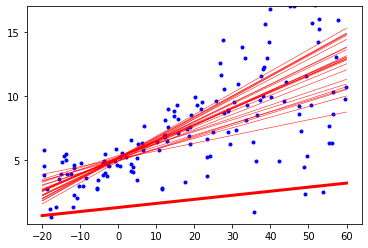

In [83]:

plt.plot(x, y, 'b.', label='observed');

yhats_ep = [model_ep(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats_ep):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 25:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
        avgm += m

plt.plot(x_tst, avgm/len(yhats_ep), 'r', label='overall mean', linewidth=3)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.show()

## Aleatoric & Epistemic Uncertainty (Known and Unknown Unknowns)

variants of data points and uncertainty from the data set



In [61]:

model_al_ep = tfk.Sequential([
    # we can add more tfk.layers here as usual
    tfp.layers.DenseVariational(units=(1+1), 
                                make_posterior_fn=posterior_mean_field, 
                                make_prior_fn=prior_trainable, ), 
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], 
                                                       scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])


# Do inference.
model_al_ep.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
history_al_ep = model_al_ep.fit(x, y, epochs=n_epochs,)


yhat_al_ep = model_al_ep(x_tst)

Epoch 1/1000
5/5 [==============================] - 0s 607us/step - loss: 438.1609
Epoch 2/1000
5/5 [==============================] - 0s 635us/step - loss: 762.3864
Epoch 3/1000
5/5 [==============================] - 0s 605us/step - loss: 931.8202
Epoch 4/1000
5/5 [==============================] - 0s 580us/step - loss: 1072.8832
Epoch 5/1000
5/5 [==============================] - 0s 666us/step - loss: 815.1110
Epoch 6/1000
5/5 [==============================] - 0s 631us/step - loss: 656.7381
Epoch 7/1000
5/5 [==============================] - 0s 585us/step - loss: 594.7875
Epoch 8/1000
5/5 [==============================] - 0s 674us/step - loss: 468.6723
Epoch 9/1000
5/5 [==============================] - 0s 621us/step - loss: 342.1885
Epoch 10/1000
5/5 [==============================] - 0s 556us/step - loss: 989.6067
Epoch 11/1000
5/5 [==============================] - 0s 576us/step - loss: 420.5533
Epoch 12/1000
5/5 [==============================] - 0s 538us/step - loss: 836.3311


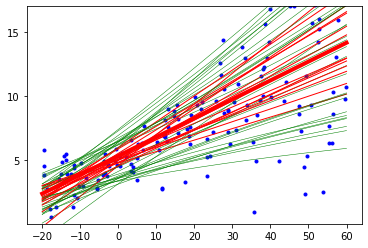

In [91]:


plt.plot(x, y, 'b.', label='observed');

yhats_al_ep = [model_al_ep(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats_al_ep):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 15:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
        plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
        plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
    avgm += m
plt.plot(x_tst, avgm/len(yhats_al_ep), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));


- Everything seems good, not only we model and learn the variety of data points but also we model and learn the uncertainty of the data set.

- However, now the question is, what make us think that a line should represent data?!
    - What if we don’t know the functional relationship between the inputs and the labels?

- Why not to use a richer distribution to fit our data?! 

- (Variational) Gaussian Process is the solution. More so, VGP treats the loss_fn as RV too.








In [99]:
# Custom PSD Kernel
class RBFKernelFn(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype = kwargs.get('dtype', None)
        
        self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')
        self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')
        
    def call(self, x):
        # Never called -- this is just a layer so it can hold variables
        # in a way Keras understands.
        return x
    
    @property
    def kernel(self):
        return tfp.math.psd_kernels.ExponentiatedQuadratic(
            amplitude=tf.nn.softplus(0.1 * self._amplitude),
            length_scale=tf.nn.softplus(5. * self._length_scale)
        )
    
    

In [103]:
# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')

# Build model_vgp.
num_inducing_points = 40
model_vgp = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1]),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(*x_range, num=num_inducing_points,
                        dtype=x.dtype)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(
            tf.constant_initializer(np.array(0.54).astype(x.dtype))),
    ),
])

# Do inference.
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])

model_vgp.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model_vgp.fit(x, y, batch_size=batch_size, epochs=1000, verbose=True)


yhat_vgp = model_vgp(x_tst)


/home/soroosh/tfGvenv/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/home/soroosh/tfGvenv/lib/python3.6/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:364: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


Epoch 1/1000
5/5 [==============================] - 2s 1ms/step - loss: 1318.2912
Epoch 2/1000
5/5 [==============================] - 0s 988us/step - loss: 1256.3968
Epoch 3/1000
5/5 [==============================] - 0s 967us/step - loss: 1209.8496
Epoch 4/1000
5/5 [==============================] - 0s 1ms/step - loss: 1180.8797
Epoch 5/1000
5/5 [==============================] - 0s 1ms/step - loss: 1114.6177
Epoch 6/1000
5/5 [==============================] - 0s 1ms/step - loss: 1081.2828
Epoch 7/1000
5/5 [==============================] - 0s 994us/step - loss: 1057.7568
Epoch 8/1000
5/5 [==============================] - 0s 965us/step - loss: 986.1297
Epoch 9/1000
5/5 [==============================] - 0s 959us/step - loss: 972.6025
Epoch 10/1000
5/5 [==============================] - 0s 950us/step - loss: 964.3170
Epoch 11/1000
5/5 [==============================] - 0s 978us/step - loss: 945.7627
Epoch 12/1000
5/5 [==============================] - 0s 965us/step - loss: 915.4200
Ep

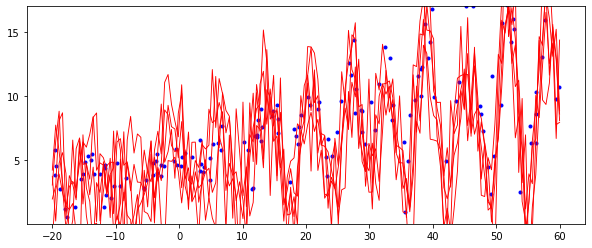

In [110]:
plt.figure(figsize=(10, 4))
plt.plot(x, y, 'b.', label='observed');

num_samples = 5
for i in range(num_samples):
    sample_ = yhat_vgp.sample().numpy()
    plt.plot(x_tst, sample_[..., 0].T, 'r', linewidth=0.9, label='ensemble means' if i == 0 else None);

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));